<a href="https://colab.research.google.com/github/spaceship17/Data-Analysis-Series/blob/main/finding_water_consumption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Water Efficiency Data Analysis Findings:

1. Average water consumption (PCC) in the region: 152.69 liters per person per day.

2. Top 3 customer segments by water consumption:
   CACI
G - Struggling single pensioners                 196.931429
D - Comfortable mid-life established families    196.218846
0 - Unknown                                      159.130000

3. Water consumption patterns by occupancy:
   OCCUPANCY
6     73.500000
8     87.500000
5     90.305882
7     91.500000
3    116.537037
2    123.361347
1    182.773016
4    246.587736

4. Key correlations:
   - PCC vs Age: -0.04
   - PCC vs Occupancy: -0.01
   - PCC vs IMD: -0.01

5. Visualizations have been saved as 'pcc_by_occupancy.png' and 'pcc_vs_age.png'.

Further actions and analyses:
1. Investigate reasons for high consumption in top CACI segments.
2. Develop targeted water efficiency programs for high-consumption groups.
3. Analyze seasonal variations in water consumption (if data available).
4. Conduct customer surv

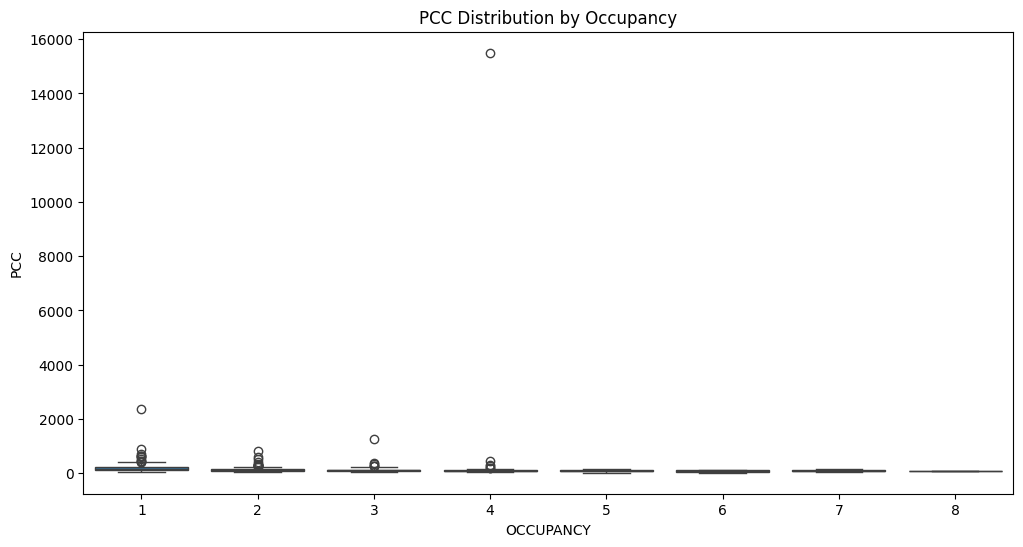

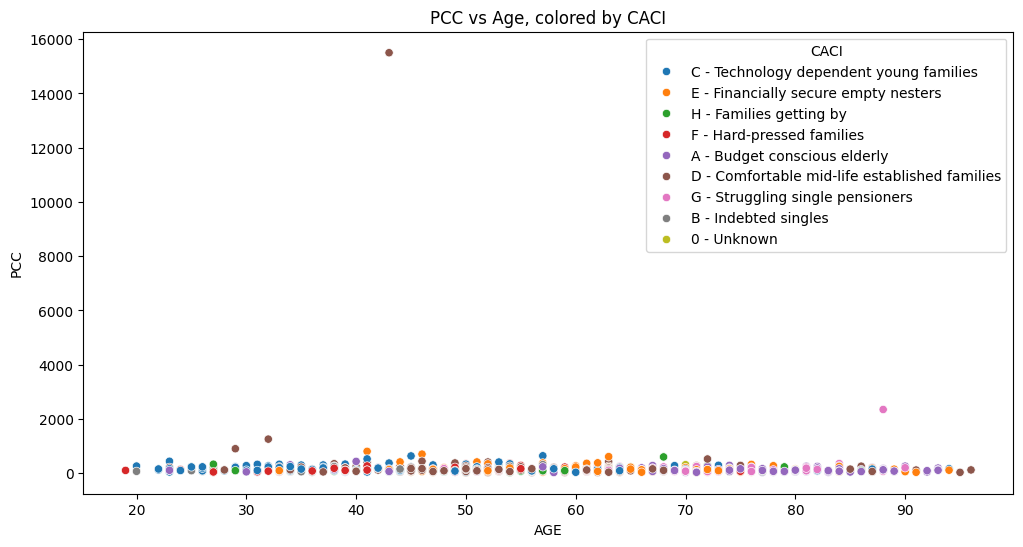

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df = pd.read_excel('/content/data.xlsx')  # Assuming the data is in a CSV file

# Basic statistical analysis
summary_stats = df.describe()

# Analyze water consumption (PCC) patterns
avg_pcc = df['PCC'].mean()
pcc_by_caci = df.groupby('CACI')['PCC'].mean().sort_values(ascending=False)  # Changed from descending=True to ascending=False
pcc_by_occupancy = df.groupby('OCCUPANCY')['PCC'].mean().sort_values()

# Analyze correlations
correlation_matrix = df[['PCC', 'AGE', 'OCCUPANCY', 'IMD']].corr()

# Visualizations
plt.figure(figsize=(12, 6))
sns.boxplot(x='OCCUPANCY', y='PCC', data=df)
plt.title('PCC Distribution by Occupancy')
plt.savefig('pcc_by_occupancy.png')

plt.figure(figsize=(12, 6))
sns.scatterplot(x='AGE', y='PCC', hue='CACI', data=df)
plt.title('PCC vs Age, colored by CACI')
plt.savefig('pcc_vs_age.png')

# Prepare summary of findings
findings = f"""
Water Efficiency Data Analysis Findings:

1. Average water consumption (PCC) in the region: {avg_pcc:.2f} liters per person per day.

2. Top 3 customer segments by water consumption:
   {pcc_by_caci.head(3).to_string()}

3. Water consumption patterns by occupancy:
   {pcc_by_occupancy.to_string()}

4. Key correlations:
   - PCC vs Age: {correlation_matrix.loc['PCC', 'AGE']:.2f}
   - PCC vs Occupancy: {correlation_matrix.loc['PCC', 'OCCUPANCY']:.2f}
   - PCC vs IMD: {correlation_matrix.loc['PCC', 'IMD']:.2f}

5. Visualizations have been saved as 'pcc_by_occupancy.png' and 'pcc_vs_age.png'.

Further actions and analyses:
1. Investigate reasons for high consumption in top CACI segments.
2. Develop targeted water efficiency programs for high-consumption groups.
3. Analyze seasonal variations in water consumption (if data available).
4. Conduct customer surveys to understand behavioral factors affecting water use.
5. Evaluate the effectiveness of existing water efficiency initiatives.
"""

print(findings)

# Save findings to a file
with open('water_efficiency_findings.txt', 'w') as f:
    f.write(findings)

In [ ]:
df.columns

Index(['ID', 'PCC', 'IMD', 'CACI', 'AGE', 'OCCUPANCY', 'TARIFF',
       'CUSTOMER_EMPLOYMENT_STATUS', 'CUSTOMER_HOME_OWNER_STATUS'],
      dtype='object')

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



Outliers:
      ID      PCC   IMD  AGE  OCCUPANCY  cluster  distance_to_centroid
11    12     60.6   1.0   64          5        2              2.600288
59    60     87.5   3.0   41          8        2              4.038823
180  181     70.6   1.0   83          6        2              3.509056
187  188     39.8   2.0   54          7        2              3.414154
207  208     15.2  10.0   50          6        2              2.168140
299  300   1254.1   6.0   32          3        2              2.600688
322  323     32.3   7.0   64          6        2              2.160491
351  352  15500.0   6.0   43          4        3              0.000000
408  409    129.5   1.0   48          6        2              2.958630
467  468     93.1   1.0   36          6        2              3.046664
625  626    143.2   2.0   46          7        2              3.405184
715  716   2346.3   4.0   88          1        1              4.636638
828  829     87.6   1.0   66          5        2              2.63

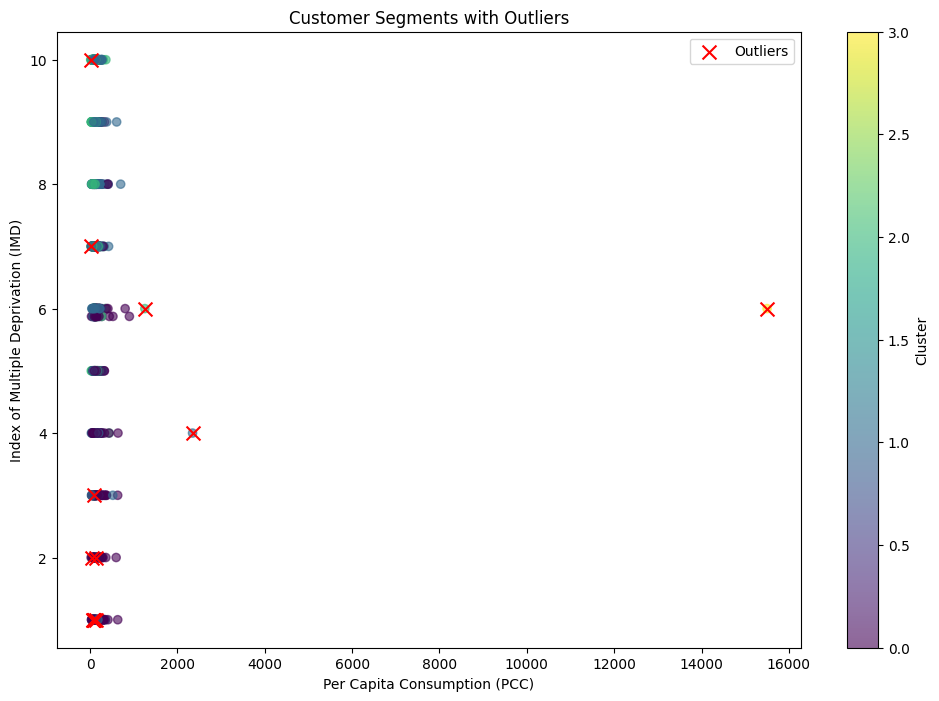

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

# Load the data
# df = pd.read_csv('water_consumption_data.csv')

# Select features for clustering
features = ['PCC', 'IMD', 'AGE', 'OCCUPANCY']

# Impute missing values
imputer = SimpleImputer(strategy='mean')
imputed_features = imputer.fit_transform(df[features])

# Normalize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(imputed_features)

# Perform K-means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
df['cluster'] = kmeans.fit_predict(scaled_features)

# Calculate distances to cluster centroids
distances = cdist(scaled_features, kmeans.cluster_centers_, metric='euclidean')
df['distance_to_centroid'] = np.min(distances, axis=1)

# Identify outliers based on distance to centroid
distance_threshold = df['distance_to_centroid'].mean() + 3 * df['distance_to_centroid'].std()
df['is_distance_outlier'] = df['distance_to_centroid'] > distance_threshold

# Identify outliers based on extreme values (e.g., more than 3 std devs from mean for each feature)
for feature in features:
    feature_mean = df[feature].mean()
    feature_std = df[feature].std()
    df[f'is_{feature}_outlier'] = (df[feature] < (feature_mean - 3*feature_std)) | (df[feature] > (feature_mean + 3*feature_std))

# Combine all outlier flags
df['is_outlier'] = df['is_distance_outlier'] | df['is_PCC_outlier'] | df['is_IMD_outlier'] | df['is_AGE_outlier'] | df['is_OCCUPANCY_outlier']

# Print outliers
print("\nOutliers:")
outliers = df[df['is_outlier']]
print(outliers[['ID'] + features + ['cluster', 'distance_to_centroid']])

# Analyze clusters (excluding outliers)
for cluster in range(4):
    cluster_data = df[(df['cluster'] == cluster) & (~df['is_outlier'])]
    print(f"\nCluster {cluster} (excluding outliers):")
    print(cluster_data[features].describe())

# Visualize clusters and outliers
plt.figure(figsize=(12, 8))
scatter = plt.scatter(imputed_features[:, 0], imputed_features[:, 1],
                      c=df['cluster'], cmap='viridis', alpha=0.6)
plt.scatter(imputed_features[df['is_outlier'], 0], imputed_features[df['is_outlier'], 1],
            color='red', marker='x', s=100, label='Outliers')
plt.xlabel('Per Capita Consumption (PCC)')
plt.ylabel('Index of Multiple Deprivation (IMD)')
plt.title('Customer Segments with Outliers')
plt.colorbar(scatter, label='Cluster')
plt.legend()
plt.show()

Mean Squared Error: 1197495.0154537475
R-squared Score: -0.008259923643667788

Feature ranking:
1. AGE (0.410095)
2. IMD (0.138853)
3. CUSTOMER_HOME_OWNER_STATUS_Joint Owner (0.135593)
4. OCCUPANCY (0.112982)
5. CUSTOMER_EMPLOYMENT_STATUS_missing (0.052584)
6. CUSTOMER_HOME_OWNER_STATUS_missing (0.030476)
7. CUSTOMER_EMPLOYMENT_STATUS_Retired (0.029674)
8. CUSTOMER_HOME_OWNER_STATUS_Owner (0.027609)
9. CUSTOMER_HOME_OWNER_STATUS_Tenant (0.017510)
10. CUSTOMER_EMPLOYMENT_STATUS_Unemployed (0.016604)
11. CUSTOMER_EMPLOYMENT_STATUS_Employed (0.016422)
12. CUSTOMER_EMPLOYMENT_STATUS_Self-employed (0.005092)
13. CUSTOMER_HOME_OWNER_STATUS_Tenant Unfurnished (0.002569)
14. CUSTOMER_EMPLOYMENT_STATUS_Not known (0.001497)
15. CUSTOMER_EMPLOYMENT_STATUS_Part Time or Temporary (0.001425)
16. CUSTOMER_HOME_OWNER_STATUS_Not Known (0.000635)
17. CUSTOMER_EMPLOYMENT_STATUS_Student (0.000214)
18. CUSTOMER_EMPLOYMENT_STATUS_Homemaker (0.000167)


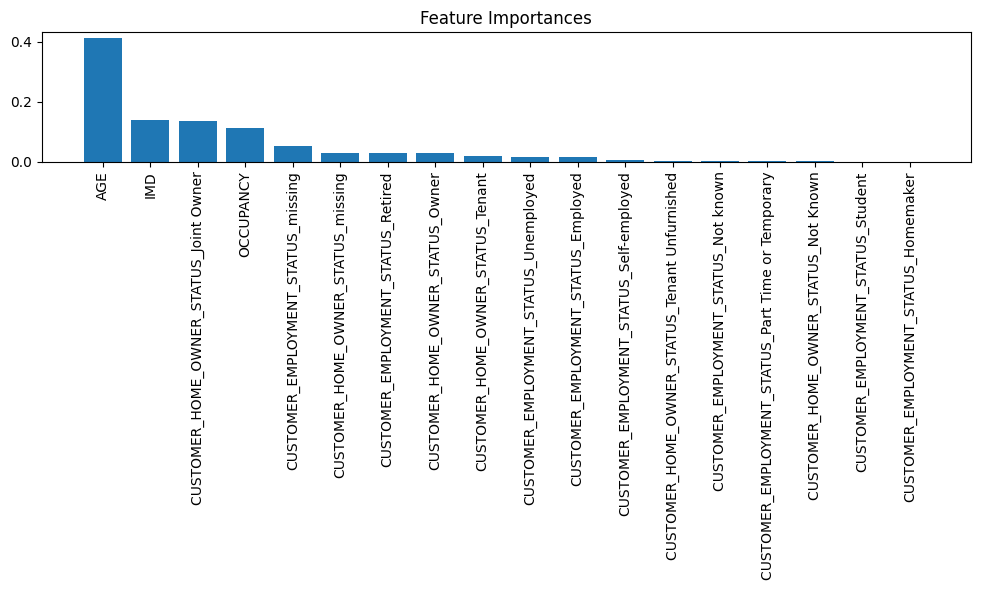


Example Prediction:
Predicted PCC: 173.23


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Assuming df is already loaded
# Separate features and target
X = df[['IMD', 'AGE', 'OCCUPANCY', 'CUSTOMER_EMPLOYMENT_STATUS', 'CUSTOMER_HOME_OWNER_STATUS']]
y = df['PCC']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create preprocessor
numeric_features = ['IMD', 'AGE', 'OCCUPANCY']
categorical_features = ['CUSTOMER_EMPLOYMENT_STATUS', 'CUSTOMER_HOME_OWNER_STATUS']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create pipeline
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Fit the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

# Feature importance
feature_importance = model.named_steps['regressor'].feature_importances_
feature_names = (numeric_features +
                 model.named_steps['preprocessor']
                     .named_transformers_['cat']
                     .named_steps['onehot']
                     .get_feature_names_out(categorical_features).tolist())

# Sort feature importances in descending order
indices = np.argsort(feature_importance)[::-1]

# Print the feature ranking
print("\nFeature ranking:")
for f in range(len(feature_names)):
    print("%d. %s (%f)" % (f + 1, feature_names[indices[f]], feature_importance[indices[f]]))

# Plot feature importances
plt.figure(figsize=(10,6))
plt.title("Feature Importances")
plt.bar(range(len(feature_names)), feature_importance[indices])
plt.xticks(range(len(feature_names)), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

# Function to predict PCC for new data
def predict_pcc(imd, age, occupancy, employment_status, home_owner_status):
    new_data = pd.DataFrame({
        'IMD': [imd],
        'AGE': [age],
        'OCCUPANCY': [occupancy],
        'CUSTOMER_EMPLOYMENT_STATUS': [employment_status],
        'CUSTOMER_HOME_OWNER_STATUS': [home_owner_status]
    })
    return model.predict(new_data)[0]

# Example prediction
print("\nExample Prediction:")
print(f"Predicted PCC: {predict_pcc(5, 40, 2, 'Employed', 'Owner'):.2f}")